In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Spiliting data

**In this subtask 1** : We splitted data into two parts of subtask 1 dataset

In [ ]:
# code split data: unseen users validation (15% user) và  train set (85% user)
def simple_split_data(file_path, out_dir, val_size=0.15, seed=42):
    """
    Splitting Data 2 parts: Train và Validation based on user_id.
    """
    # 1. Load Data
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    df = pd.read_csv(file_path)

    os.makedirs(out_dir, exist_ok=True)

    # 2. Sử dụng GroupShuffleSplit để chia theo User ID
    # val_size=0.15 nghĩa là 15% số lượng user sẽ vào tập Validation
    splitter = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)

    train_idx, val_idx = next(splitter.split(df, groups=df['user_id']))

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_users = set(train_df['user_id'].unique())
    val_users = set(val_df['user_id'].unique())
    intersection = train_users.intersection(val_users)

    print("-" * 30)
    print(f"total rows of data: {len(df)}")
    print(f"1. Train Set:      {len(train_df)} sample ({len(train_users)} users)")
    print(f"2. Validation Set: {len(val_df)} sample ({len(val_users)} users)")
    print("-" * 30)

    if len(intersection) > 0:
        print(f" Warning: having {len(intersection)} user intersection!")
    else:
        print("Check Leakage: Safe (No User Intersection).")

    # 4.save file csv
    train_df.to_csv(os.path.join(out_dir, 'train_split.csv'), index=False)
    val_df.to_csv(os.path.join(out_dir, 'val_split.csv'), index=False)
    print(f"Save at: {out_dir}")

# run function to create csv file
simple_split_data(url, out_dir, val_size=0.15, seed=42)

# 2. Training

>>> [1] Loading Data...
 - Fixing text spacing...
 - Train: 2252 | Val: 512
>>> [2] Applying Sliding Window (Size=4)...
>>> [3] Tokenizing...
>>> [4] Initializing Model (Soft MoE + MeanPool)...
 - Initializing SemEval Evaluator...
🚀 >>> [5] Starting Training...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Score,V R All,V R In,V R Bet,V Mae,A R All,A R In,A R Bet,A Mae
1,0.693500,0.793878,0.228749,0.416300,0.506100,0.317700,0.914500,0.041200,0.122200,-0.040400,0.485400
2,0.501400,0.575553,0.521692,0.649400,0.617600,0.679000,0.668300,0.394000,0.352100,0.434400,0.509500
3,0.397900,0.509162,0.523391,0.704500,0.670600,0.735500,0.706100,0.342300,0.460900,0.211600,0.405500
4,0.355900,0.503450,0.603061,0.616400,0.633900,0.598300,0.765500,0.589700,0.473200,0.685900,0.386200
5,0.288100,0.487691,0.550452,0.650000,0.711500,0.578800,0.757500,0.450900,0.444100,0.457600,0.400600
6,0.231600,0.477358,0.525564,0.562200,0.596700,0.525600,0.733500,0.489000,0.529200,0.446500,0.327300
7,0.189900,0.493157,0.626650,0.703700,0.658900,0.743600,0.671000,0.549600,0.395800,0.673400,0.397600
8,0.198500,0.499791,0.510136,0.566400,0.634700,0.489400,0.753100,0.453800,0.415700,0.490400,0.388400


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

plotting for training and score...
>>> Generating Training History Plots...


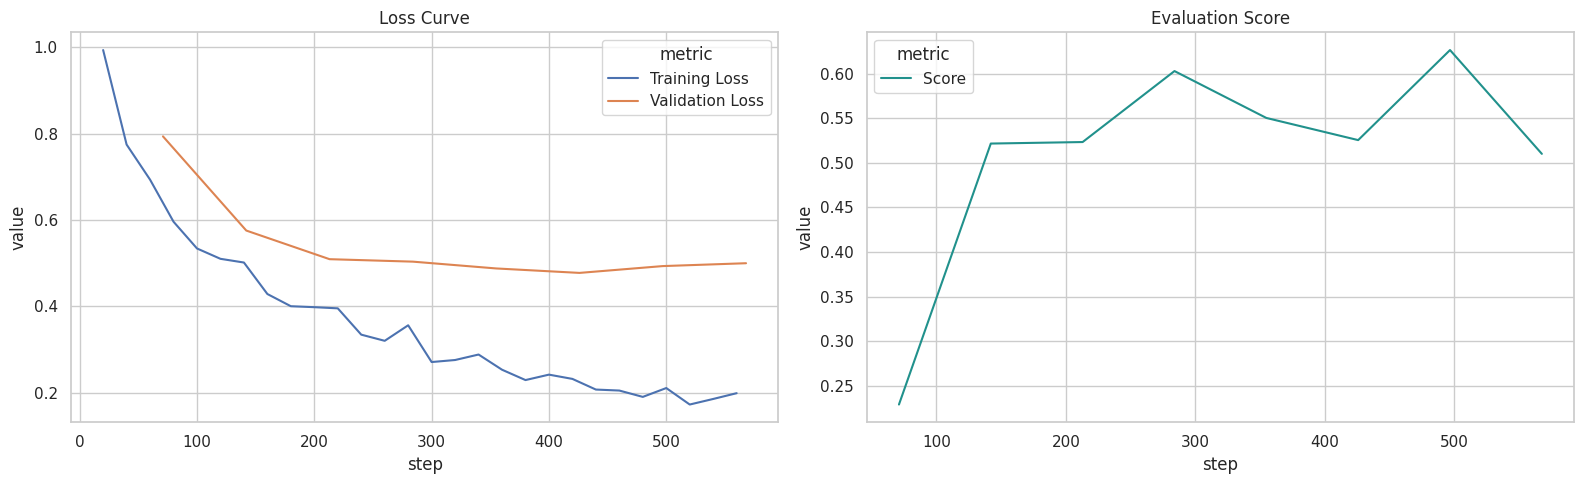

>>> [6] Saving...
Zipped to final_model.zip
>>> [7] Final Evaluation...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



FINAL RESULTS (UNSEEN USERS)
OVERALL SCORE: 0.5960
--------------------------------------------------
VALENCE (Tích cực/Tiêu cực):
   • Composite R (All): 0.6566
   • Within-User R:     0.6650
   • Between-User R:    0.6480
   • MAE (Sai số):      0.6614
-------------------------
AROUSAL (Kích động/Bình tĩnh):
   • Composite R (All): 0.5355
   • Within-User R:     0.6072
   • Between-User R:    0.4551
   • MAE (Sai số):      0.3507


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, set_seed
)
import os
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, gaussian_kde
from sklearn.model_selection import GroupShuffleSplit
import warnings

warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

# ============================================================
# 1. CONFIGURATION
# ============================================================
class Config:
    # MODEL
    model_names = {
        "roberta_sentiment": "cardiffnlp/twitter-roberta-base-sentiment-latest"
    }
    
    train_path = "/kaggle/input/semevaldataset/Dataset/data_sub1/train_split.csv"
    val_path = "/kaggle/input/semevaldataset/Dataset/data_sub1/val_split.csv"
    output_dir = './semeval_model_subtask1'

    # DATA & SEQUENCE
    window_size = 4   # Context window
    max_seq_length = 384

    # TRAINING HYPERPARAMETERS
    per_device_train_batch_size = 16
    gradient_accumulation_steps = 2
    num_train_epochs = 8
    warmup_ratio = 0.1
    learning_rate = 2e-5
    weight_decay = 0.1
    logging_steps = 20
    

    # HARDWARE
    fp16 = torch.cuda.is_available()
    seed = 3407

set_seed(Config.seed)

# ============================================================
# 2. HELPER FUNCTIONS (PREPROCESSING)
# ============================================================
def fix_spacing(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+'\s+", "'", text)
    return text.strip()

def sliding_window_context(df, window_size=Config.window_size):
    """Tạo context từ các bài post trước đó"""
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
    new_data = []

    for uid, group in df.groupby('user_id'):
        texts = group['text'].values
        vals = group['valence'].values
        aros = group['arousal'].values

        for i in range(len(texts)):
            context_list = []
            # get (window_size - 1) previous
            for k in range(1, window_size):
                prev_idx = i - k
                if prev_idx >= 0:
                    context_list.insert(0, str(texts[prev_idx]))

            current_text = str(texts[i])
            if len(context_list) > 0:
                context_str = ' </s> '.join(context_list)
                full_input = f"{context_str} </s> {current_text}"
            else:
                full_input = current_text

            new_data.append({
                'user_id': uid,
                'input_text': full_input,
                'labels': [vals[i], aros[i]]
            })
    return pd.DataFrame(new_data)

class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=Config.max_seq_length):
        self.tokenizer = tokenizer
        self.texts = df['input_text'].values
        self.labels = df['labels'].values
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length",
            max_length=self.max_len, 
            return_tensors="pt"
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),      
            'attention_mask': encoding['attention_mask'].flatten(), 
            'labels': torch.tensor(label, dtype=torch.float)   
        }

# ============================================================
# 3. VISUALIZATION FUNCTIONS
# ============================================================
def plot_training_history(trainer):
    """Vẽ biểu đồ Loss và Metrics"""
    print(">>> Generating Training History Plots...")
    history = trainer.state.log_history
    data = []
    for entry in history:
        step = entry.get('step', 0)
        if 'loss' in entry:
            data.append({'step': step, 'metric': 'Training Loss', 'value': entry['loss'], 'type': 'Loss'})
        elif 'eval_loss' in entry:
            data.append({'step': step, 'metric': 'Validation Loss', 'value': entry['eval_loss'], 'type': 'Loss'})
            if 'eval_score' in entry:
                data.append({'step': step, 'metric': 'Score', 'value': entry['eval_score'], 'type': 'Metric'})

    df = pd.DataFrame(data)
    if df.empty: return

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss Plot
    loss_df = df[df['type'] == 'Loss']
    if not loss_df.empty:
        sns.lineplot(data=loss_df, x='step', y='value', hue='metric', ax=axes[0])
        axes[0].set_title("Loss Curve")
    
    # Score Plot
    metric_df = df[df['type'] == 'Metric']
    if not metric_df.empty:
        sns.lineplot(data=metric_df, x='step', y='value', hue='metric', ax=axes[1], palette='viridis')
        axes[1].set_title("Evaluation Score")
        
    plt.tight_layout()
    plt.savefig("/kaggle/working/training_history.png")
    plt.show()

def plot_predictions(trainer, test_dataset):
    """Vẽ Scatter Plot so sánh"""
    print(">>> Generating Scatter Plots...")
    preds = trainer.predict(test_dataset)
    y_pred, y_true = preds.predictions, preds.label_ids
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    titles = ["Valence", "Arousal"]
    
    for i in range(2):
        true, pred = y_true[:, i], y_pred[:, i]
        # Density plot logic
        try:
            xy = np.vstack([true, pred])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x, y, z = true[idx], pred[idx], z[idx]
            axes[i].scatter(x, y, c=z, s=20, cmap='Spectral_r')
        except:
            axes[i].scatter(true, pred, c='blue', s=20, alpha=0.5)
            
        # Ideal line
        axes[i].plot([min(true), max(true)], [min(true), max(true)], 'k--')
        r, _ = pearsonr(true, pred)
        axes[i].set_title(f"{titles[i]} (R={r:.4f})")
        axes[i].set_xlabel("Ground Truth")
        axes[i].set_ylabel("Predicted")

    plt.tight_layout()
    plt.savefig("/kaggle/working/scatter_plots.png")
    plt.show()

# ============================================================
# 4. LAYERS & MODEL (SOFT MOE + MEAN POOLING)
# ============================================================
class CCCLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        y_pred, y_true = y_pred.view(-1), y_true.view(-1)
        mu_pred, mu_true = torch.mean(y_pred), torch.mean(y_true)
        var_pred, var_true = torch.var(y_pred, unbiased=False), torch.var(y_true, unbiased=False)
        cov = torch.mean((y_pred - mu_pred) * (y_true - mu_true))
        num = 2 * cov
        den = var_pred + var_true + (mu_pred - mu_true)**2 + self.eps
        return 1.0 - (num / den)

# [LAYER 1] Mean Pooling
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, last_hidden_state, attention_mask):

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)

        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

        return sum_embeddings / sum_mask

class SoftMoEHead(nn.Module):
    def __init__(self, hidden_size, num_experts=4, output_dim=1):
        super().__init__()
        # Router
        self.gate = nn.Linear(hidden_size, num_experts)
        # Experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.LayerNorm(hidden_size),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_size, output_dim)
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        # x: [Batch, Hidden]
        gate_logits = self.gate(x)
        gate_weights = torch.softmax(gate_logits, dim=1) # Soft assignment
        
        # Stack output: [Batch, Num_Experts, Output_Dim]
        expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        
        # Weighted Sum
        output = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs, dim=1)
        return output
        
class Subtask1Model(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.config.hidden_size

        # 1. MEAN POOLING
        self.pooler = MeanPooling()

        # 2. SOFT MOE HEADS
        self.valence_moe = SoftMoEHead(hidden_size, num_experts=4, output_dim=1)
        self.arousal_moe = SoftMoEHead(hidden_size, num_experts=4, output_dim=1)

        self.loss_fct = CCCLoss()

        # Init weights 
        self._init_weights(self.valence_moe)
        self._init_weights(self.arousal_moe)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None: module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, (nn.ModuleList, nn.Sequential)):
            for sub in module: self._init_weights(sub)
        
        elif isinstance(module, SoftMoEHead):
            self._init_weights(module.gate)
            self._init_weights(module.experts)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        # Mean Pooling
        feature_vector = self.pooler(outputs.last_hidden_state, attention_mask)

        # Soft MoE
        val_pred = self.valence_moe(feature_vector)
        aro_pred = self.arousal_moe(feature_vector)

        logits = torch.cat((val_pred, aro_pred), dim=1)

        loss = None
        if labels is not None:
            # Calculate CCC Loss
            loss_v = self.loss_fct(val_pred, labels[:, 0])
            loss_a = self.loss_fct(aro_pred, labels[:, 1])
            
            # Weighted Sum
            loss = 0.4 * loss_v + 0.6 * loss_a
            
        return {"loss": loss, "logits": logits}

# ============================================================
# 5. METRICS & EVALUATOR
# ============================================================
def calculate_semeval_metrics(user_ids, preds, labs):
    user_ids, preds, labs = np.array(user_ids), np.array(preds), np.array(labs)
    unique_users = np.unique(user_ids)
    
    # --- 1. Within-User Analysis ---
    corrs, maes = [], []
    for u in unique_users:
        mask = (user_ids == u)
        if np.sum(mask) < 2: continue 
        
        # std > 0
        if np.std(preds[mask]) > 0 and np.std(labs[mask]) > 0:
            r, _ = pearsonr(preds[mask], labs[mask])
            if not np.isnan(r): corrs.append(r)
        
        maes.append(np.mean(np.abs(preds[mask] - labs[mask])))
    
    r_within = np.mean(corrs) if corrs else 0.0
    mae_within = np.mean(maes) if maes else 0.0

    # --- 2. Between-User Analysis ---
    user_means_pred = [np.mean(preds[user_ids == u]) for u in unique_users]
    user_means_lab = [np.mean(labs[user_ids == u]) for u in unique_users]
    
    if len(user_means_pred) > 1:
        r_between, _ = pearsonr(user_means_pred, user_means_lab)
        if np.isnan(r_between): r_between = 0.0
    else: r_between = 0.0
    
    mae_between = np.mean(np.abs(np.array(user_means_pred) - np.array(user_means_lab)))

    # --- 3. Composite Scores (Fisher Z-transformation) ---
    def safe_arctanh(x): return np.arctanh(np.clip(x, -0.99, 0.99))
    
    r_composite = np.tanh(0.5 * (safe_arctanh(r_within) + safe_arctanh(r_between)))
    mae_composite = np.tanh(0.5 * (safe_arctanh(mae_within) + safe_arctanh(mae_between)))

    # return metrics to compare
    return {
        "r_within": r_within,
        "r_between": r_between,
        "r_composite": r_composite,
        "mae_within": mae_within,
        "mae_between": mae_between,
        "mae_composite": mae_composite
    }

class SemEvalEvaluator:
    def __init__(self, val_df):
        # Lưu lại user_ids để dùng lúc evaluate
        self.user_ids = val_df['user_id'].values

    def __call__(self, eval_pred):
        predictions, labels = eval_pred
        if isinstance(predictions, tuple): predictions = predictions[0]
        
        # Tính toán cho Valence (cột 0)
        m_v = calculate_semeval_metrics(self.user_ids, predictions[:, 0], labels[:, 0])
        
        # Tính toán cho Arousal (cột 1)
        m_a = calculate_semeval_metrics(self.user_ids, predictions[:, 1], labels[:, 1])
        
        # Log đầy đủ ra bảng
        return {
            "score": (m_v['r_composite'] + m_a['r_composite']) / 2,
            
            # --- VALENCE METRICS ---
            "V_R_all": round(m_v['r_composite'], 4),
            "V_R_in":  round(m_v['r_within'], 4),   # Within
            "V_R_bet": round(m_v['r_between'], 4),  # Between
            "V_MAE":   round(m_v['mae_composite'], 4),
            
            # --- AROUSAL METRICS ---
            "A_R_all": round(m_a['r_composite'], 4),
            "A_R_in":  round(m_a['r_within'], 4),   # Within
            "A_R_bet": round(m_a['r_between'], 4),  # Between
            "A_MAE":   round(m_a['mae_composite'], 4),
        }


# ============================================================
# 6. MAIN TRAINING LOOP
# ============================================================
def train_model():
    print(">>> [1] Loading Data...")
    if not os.path.exists(Config.train_path):
        print(f"ERROR: File not found at {Config.train_path}"); return

    # 1. Đọc file
    train_df = pd.read_csv(Config.train_path)
    val_df = pd.read_csv(Config.val_path)
    print(" - Fixing text spacing...")
    train_df['text'] = train_df['text'].apply(fix_spacing)
    val_df['text'] = val_df['text'].apply(fix_spacing)
    print(f" - Train: {len(train_df)} | Val: {len(val_df)}")

    # 3. Sliding Window
    print(f">>> [2] Applying Sliding Window (Size={Config.window_size})...")
    train_ctx = sliding_window_context(train_df, Config.window_size)
    val_ctx = sliding_window_context(val_df, Config.window_size) 

    # 4. Tokenizing
    print(">>> [3] Tokenizing...")
    tokenizer = AutoTokenizer.from_pretrained(Config.model_names['roberta_sentiment']) 
    train_ds = EmotionDataset(train_ctx, tokenizer)
    val_ds = EmotionDataset(val_ctx, tokenizer)

    # 5. Model Init
    print(">>> [4] Initializing Model (Soft MoE + MeanPool)...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Subtask1Model(Config.model_names['roberta_sentiment']).to(device)

    # 6. Evaluator
    print(" - Initializing SemEval Evaluator...")
    semeval_evaluator = SemEvalEvaluator(val_ctx) 

    training_args = TrainingArguments(
        output_dir=Config.output_dir,
        learning_rate=Config.learning_rate,
        per_device_train_batch_size=Config.per_device_train_batch_size,
        per_device_eval_batch_size=Config.per_device_train_batch_size * 2,
        gradient_accumulation_steps=Config.gradient_accumulation_steps,
        num_train_epochs=Config.num_train_epochs,
        warmup_ratio=Config.warmup_ratio,
        group_by_length=True,
        dataloader_num_workers=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="score",
        greater_is_better=True,
        fp16=Config.fp16,
        save_total_limit=1,
        remove_unused_columns=False,
        report_to="none",
        logging_steps=Config.logging_steps,
        weight_decay=Config.weight_decay,
        save_safetensors=True,
        seed=Config.seed
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=semeval_evaluator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print("🚀 >>> [5] Starting Training...")
    trainer.train()

    print(f"plotting for training and score...")
    plot_training_history(trainer)
    
    print(">>> [6] Saving...")
    out_path = "./final_soft_sparse_moeMP_model"
    trainer.save_model(out_path)
    tokenizer.save_pretrained(out_path)
    trainer.save_state()
    
    # Zip model
    try:
        shutil.make_archive("/kaggle/working/final_model", 'zip', out_path)
        print("Zipped to final_model.zip")
    except: pass

    print(">>> [7] Final Evaluation...")
    metrics = trainer.evaluate()
    #plot_predictions(trainer, val_ds) 

    # --- Detailed Report ---
    print("\n" + "="*50)
    print(f"FINAL RESULTS (UNSEEN USERS)")
    print("="*50)
    print(f"OVERALL SCORE: {metrics['eval_score']:.4f}")
    print("-" * 50)
    
    # Báo cáo Valence
    print("VALENCE (Tích cực/Tiêu cực):")
    print(f"   • Composite R (All): {metrics['eval_V_R_all']:.4f}")
    print(f"   • Within-User R:     {metrics['eval_V_R_in']:.4f}")
    print(f"   • Between-User R:    {metrics['eval_V_R_bet']:.4f}")
    print(f"   • MAE (Sai số):      {metrics['eval_V_MAE']:.4f}")
    print("-" * 25)

    # Báo cáo Arousal
    print("AROUSAL (Kích động/Bình tĩnh):")
    print(f"   • Composite R (All): {metrics['eval_A_R_all']:.4f}")
    print(f"   • Within-User R:     {metrics['eval_A_R_in']:.4f}")
    print(f"   • Between-User R:    {metrics['eval_A_R_bet']:.4f}")
    print(f"   • MAE (Sai số):      {metrics['eval_A_MAE']:.4f}")
    print("=" * 50)

if __name__ == "__main__":
    train_model()

In [2]:
# download from kaggle output
from IPython.display import FileLink
FileLink(r'final_model.zip')

/kaggle/working/final_model.zip

# 3. Inference And Submission

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModel
import os
import re
from tqdm.auto import tqdm

# ============================================================
# 1. INFERENCE CONFIGURATION
# ============================================================
class InferenceConfig:
    # Base model name (must match training)
    base_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    
    # Path to Test Data
    test_path = "/kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2a_forecasting_user_marker.csv"
    # test_path = "YOUR DIRECTION TEST PATH"
    
    # [IMPORTANT] Path to the folder containing your trained model weights
    # Matches 'output_dir' or where you saved the final model
    model_path = "./final_soft_sparse_moeMP_model"
    # model_path = "YOUR DIRECTION PATH"
    output_csv = "pred_subtask1.csv"
    
    # Must match training config
    window_size = 4
    max_seq_length = 384
    batch_size = 32

    num_experts = 4
    top_k = 2
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# 2. MODEL ARCHITECTURE
# ============================================================

# [LAYER 1] Mean Pooling
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# [LAYER 2] Soft MoE Head
class SoftMoEHead(nn.Module):
    def __init__(self, hidden_size, num_experts=4, output_dim=1):
        super().__init__()
        self.gate = nn.Linear(hidden_size, num_experts)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.LayerNorm(hidden_size),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_size, output_dim)
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        gate_logits = self.gate(x)
        gate_weights = torch.softmax(gate_logits, dim=1)
        expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        
        # Weighted Sum
        output = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs, dim=1)
        
        return output

class Subtask1Model(nn.Module):
    def __init__(self, model_name, num_experts=4):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.config.hidden_size

        # 1. MEAN POOLING
        self.pooler = MeanPooling()

        # 2. SOFT MOE HEADS
        # Passing num_experts explicitly to match training config
        self.valence_moe = SoftMoEHead(hidden_size, num_experts=num_experts, output_dim=1)
        self.arousal_moe = SoftMoEHead(hidden_size, num_experts=num_experts, output_dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        feature_vector = self.pooler(outputs.last_hidden_state, attention_mask)

        # Soft MoE Prediction
        val_pred = self.valence_moe(feature_vector)
        aro_pred = self.arousal_moe(feature_vector)

        # Concatenate
        return torch.cat((val_pred, aro_pred), dim=1)

# ============================================================
# 3. DATA PROCESSING
# ============================================================
def fix_spacing(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+'\s+", "'", text)
    return text.strip()

def prepare_test_data(path, window_size):
    print(f">>> Processing Test Data from {path}...")
    if not os.path.exists(path):
        print("Error: Test file not found!")
        return None

    df = pd.read_csv(path)
    df['text'] = df['text'].apply(fix_spacing)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
    
    new_data = []
    # Determine ID column name
    id_col = 'text_id' if 'text_id' in df.columns else 'id'
    
    for uid, group in df.groupby('user_id'):
        texts = group['text'].values
        ids = group[id_col].values
        
        for i in range(len(texts)):
            context_list = []
            # Sliding Window Logic
            for k in range(1, window_size):
                prev_idx = i - k
                if prev_idx >= 0:
                    context_list.insert(0, str(texts[prev_idx]))
            
            current_text = str(texts[i])
            if len(context_list) > 0:
                context_str = ' </s> '.join(context_list)
                full_input = f"{context_str} </s> {current_text}"
            else:
                full_input = current_text
            
            new_data.append({
                'user_id': uid,
                'text_id': ids[i],
                'input_text': full_input
            })
            
    return pd.DataFrame(new_data)

class InferenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['input_text'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten()
        }

# ============================================================
# 4. RUN INFERENCE
# ============================================================
def run_inference():
    print("="*60)
    print("STARTING INFERENCE (SOFT MOE + MEAN POOLING)")
    print("="*60)

    # 1. Load Tokenizer
    print(f">>> [1/5] Loading Tokenizer...")
    try:
        # Try loading from local model folder first
        tokenizer = AutoTokenizer.from_pretrained(InferenceConfig.model_path)
    except:
        print("Local tokenizer not found, downloading base tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(InferenceConfig.base_model_name)

    # 2. Initialize Model Skeleton
    print(f">>> [2/5] Initializing Model Architecture (Experts={InferenceConfig.num_experts})...")
    try:
        # Initialize model structure using the base model config
        model = Subtask1Model(
            InferenceConfig.base_model_name, 
            num_experts=InferenceConfig.num_experts
        )
    except Exception as e:
        print(f"Error initializing model: {e}"); return

    # 3. Load Weights (Directly)
    print(f">>> [3/5] Loading Weights from: {InferenceConfig.model_path}")
    safetensors_path = os.path.join(InferenceConfig.model_path, "model.safetensors")
    bin_path = os.path.join(InferenceConfig.model_path, "pytorch_model.bin")
    
    state_dict = None
    if os.path.exists(safetensors_path):
        print(f"Loading safetensors: {safetensors_path}")
        from safetensors.torch import load_file
        state_dict = load_file(safetensors_path)
    elif os.path.exists(bin_path):
        print(f"Loading bin: {bin_path}")
        state_dict = torch.load(bin_path, map_location='cpu')
    else:
        print(f"ERROR: No weight file found in {InferenceConfig.model_path}"); return

    try:
        model.load_state_dict(state_dict)
        print("Weights Loaded Successfully!")
    except RuntimeError as e:
        print(f"\nWEIGHT MISMATCH ERROR:\n{e}")
        print(f"Tip: Check if 'num_experts' in InferenceConfig ({InferenceConfig.num_experts}) matches training.")
        return

    model.to(InferenceConfig.device)
    model.eval()

    # 4. Prepare Data & Predict
    print(f">>> [4/5] Preparing Data & Predicting...")
    test_df = prepare_test_data(InferenceConfig.test_path, InferenceConfig.window_size)
    if test_df is None: return
    
    test_ds = InferenceDataset(test_df, tokenizer, InferenceConfig.max_seq_length)
    test_loader = DataLoader(test_ds, batch_size=InferenceConfig.batch_size, shuffle=False)

    all_preds = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(InferenceConfig.device)
            attention_mask = batch['attention_mask'].to(InferenceConfig.device)
            
            logits = model(input_ids, attention_mask)
            all_preds.extend(logits.cpu().numpy())
            
    all_preds = np.array(all_preds)

    # 5. Post-processing (Clipping)
    print(f">>> [5/5] Clipping & Saving...")
    
    # Clip Valence to [-2, 2]
    all_preds[:, 0] = np.clip(all_preds[:, 0], -2.0, 2.0)
    # Clip Arousal to [0, 2]
    all_preds[:, 1] = np.clip(all_preds[:, 1], 0.0, 2.0)

    submission = pd.DataFrame({
        'user_id': test_df['user_id'],
        'text_id': test_df['text_id'],
        'pred_valence': all_preds[:, 0],
        'pred_arousal': all_preds[:, 1]
    })
    
    submission.to_csv(InferenceConfig.output_csv, index=False)
    print(f"DONE! Results saved to: {InferenceConfig.output_csv}")
    print("\nPreview:")
    print(submission.head())

if __name__ == "__main__":
    run_inference()

STARTING INFERENCE (SOFT MOE + MEAN POOLING)
>>> [1/5] Loading Tokenizer...
>>> [2/5] Initializing Model Architecture (Experts=4)...
>>> [3/5] Loading Weights from: ./final_soft_sparse_moeMP_model
Loading safetensors: ./final_soft_sparse_moeMP_model/model.safetensors
Weights Loaded Successfully!
>>> [4/5] Preparing Data & Predicting...
>>> Processing Test Data from /kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2a_forecasting_user_marker.csv...


  0%|          | 0/87 [00:00<?, ?it/s]

>>> [5/5] Clipping & Saving...
DONE! Results saved to: pred_subtask1.csv

Preview:
   user_id  text_id  pred_valence  pred_arousal
0        1      200      2.000000      0.393212
1        1      201      1.446233      1.249418
2        1      202      0.546851      1.072714
3        1      203      1.025498      1.661525
4        1      204      0.940104      1.844659
